The goal of this code is to take a stock and use regressions to try and predict its future price. 

This analysis was inspired by the following resource: https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7

In [110]:
# import wrangling/data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math

# for model generation:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

# for web scraping (source: https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460)
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

# for more text stuff (source: https://stackoverflow.com/questions/38133759/how-to-get-text-from-span-tag-in-beautifulsoup)
import re

The first step is to import the company data. In this example, I've chosen to analyze Tesla (TSLA), but any other company would work as well

In [84]:
# import company data from Yahoo
company = 'TSLA'

# access data
url = 'https://finance.yahoo.com/quote/' + company + '/history?p=' + company
response = requests.get(url)
print(response) # success

<Response [200]>


In [85]:
# parse the html with BeautifulSoup
soup = BeautifulSoup(response.text, "lxml")

In [86]:
# find all cases of the "span" tag
spans = soup.find_all('span')

In [87]:
# initialize empty columns
date = []
openPrice = []
highPrice = []
lowPrice = []
closePrice = []
adjClosePrice = []
volume = []

It seems like the relevant data exists in groups of 7, starting from a certain index and ending from a certain index. Because of this, we loop through accordingly.

In [88]:
# get text data
for i, span in enumerate(spans):
    if i >= 34 and i <= 733: # these are hardcoded, but I need to figure out a way to make these dynamic
        # get the dates:
        if i % 7 == 6:
            date.append(datetime.strptime(span.text, "%b %d, %Y"))
        # get opening price
        elif i % 7 == 0:
            openPrice.append(float(span.text))
        # get high price
        elif i % 7 == 1:
            highPrice.append(float(span.text))
        # get low price
        elif i % 7 == 2:
            lowPrice.append(float(span.text))
        # get closing price
        elif i % 7 == 3:
            closePrice.append(float(span.text))
        # get adjusted closing price
        elif i % 7 == 4:
            adjClosePrice.append(float(span.text))
        # get volumes
        elif i % 7 == 5:
            vol = span.text.replace(',', '') # take out commas, so it can be represented as an int
            volume.append(int(vol))

In [89]:
df = pd.DataFrame(list(zip(date, openPrice, highPrice, lowPrice, closePrice, adjClosePrice, volume)), 
                 columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

In [90]:
# check if it looks right
print(df.shape)
print(df.describe())

(100, 7)
             Open        High         Low       Close   Adj Close  \
count  100.000000  100.000000  100.000000  100.000000  100.000000   
mean   227.665400  231.524300  223.505800  227.581300  227.581300   
std     18.639625   18.382398   18.710379   18.853517   18.853517   
min    181.100000  186.680000  176.990000  178.970000  178.970000   
25%    219.372500  222.240000  214.077500  218.727500  218.727500   
50%    228.930000  231.875000  225.210000  228.180000  228.180000   
75%    238.985000  243.440000  233.985000  238.747500  238.747500   
max    269.000000  269.680000  262.480000  264.880000  264.880000   

             Volume  
count  1.000000e+02  
mean   9.772982e+06  
std    4.936259e+06  
min    3.225500e+06  
25%    6.188625e+06  
50%    8.248750e+06  
75%    1.121798e+07  
max    2.654710e+07  


Now, the next step is to perform some EDA and get a better sense for the data

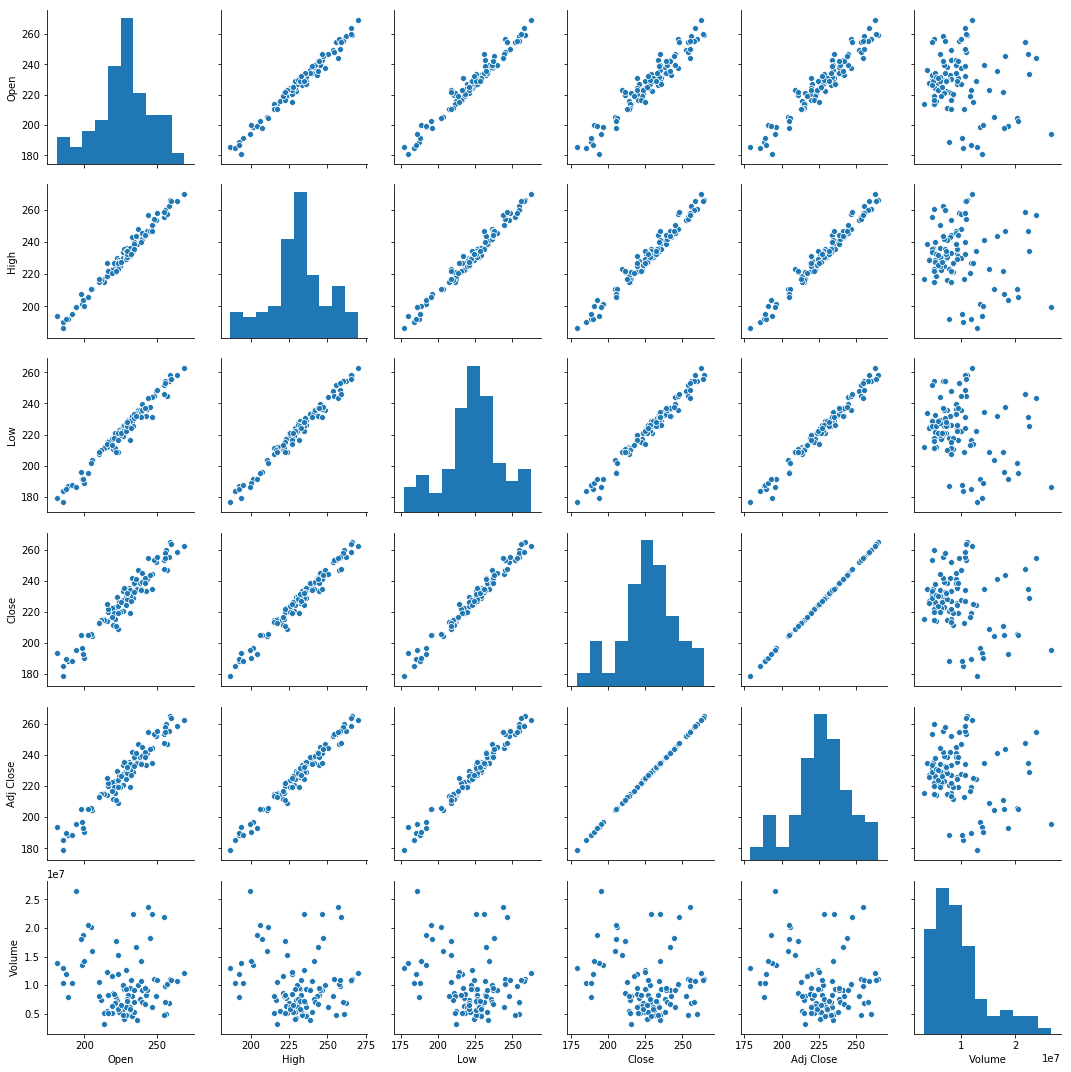

In [9]:
# Use seaborn to create pairwise plots
sns.pairplot(df) # as expected (looks pretty obvious), there is a strong linear relationship in prices

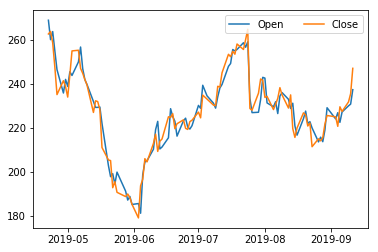

In [91]:
# For opening and closing prices prices
plt.plot(df.Date, df.Open)
plt.plot(df.Date, df.Close)
plt.legend(loc = 'upper right', ncol = 2)
plt.show()

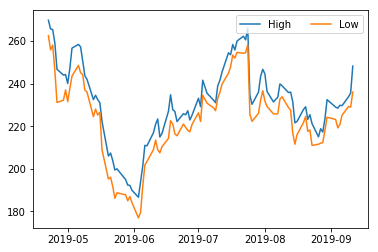

In [92]:
# for high and low prices
plt.plot(df.Date, df.High)
plt.plot(df.Date, df.Low)
plt.legend(loc = 'upper right', ncol = 2)
plt.show()

I'll do some feature engineering to look at the differences in prices over time

1. Change in high/low price for a given day
2. Change in open/close price for a given day

In [93]:
# 1. Change in high/low price for a given day
df['diff_highLow'] = df.High - df.Low

# 2. Change in open/close price for a given day
df['diff_closeOpen'] = df.Close - df.Open

We'll use only a subset of our data: adjusted closing price, volume, and the differences

In [94]:
df_small = df.loc[:, ['Adj Close', 'Volume', 'diff_highLow', 'diff_closeOpen']]

Before fitting the model, I'll perform some other preprocessing steps:

1. Since we want to predict AdjClose, we'll extract that label. We also want to separate out 5% of the data in order to forecast it

In [95]:
# get data to forecast out
forecast_out = int(math.ceil(0.05 * len(df_small)))

# create matrix of Xs (predictors) by dropping Y
X = np.array(df_small.drop(['Adj Close'], 1)) 

2. Scale the X

In [96]:
# Scale Xs
X = preprocessing.scale(X)

3. Separate training and test sets, for both X and Y

In [97]:
# separate Xs:
X_train = X[:-forecast_out]
X_test = X[-forecast_out: ]

In [98]:
# create np array for Ys
Y = np.array(df_small['Adj Close'])

# separate Ys:
Y_train = Y[:-forecast_out]
Y_test = Y[-forecast_out:]

The next step is to start fitting regression models to try and predict the stock price for a future date

The first regression model that we'll use is a simple linear regression. A linear regression will seek to minimze the least squares difference between the estimates and the true y-value. In exchange for being a model that doesn't have a lot of variance (i.e., it doesn't curve a lot and therefore overfits the data), it can be biased (e.g., one outlier can skew the line)

In [101]:
?mean_squared_error

Object `mean_squared_error` not found.


In [103]:
# create functions to evaluate accuracy
def rmse(y, y_preds):
    rmse = np.sqrt(mean_squared_error(y, y_preds))
    return rmse

In [104]:
# creating and fitting linear regression object
linReg = LinearRegression()
linReg.fit(X_train, Y_train)

# make predictions
preds_linReg = linReg.predict(X_test)

# evaluate using RMSE and r-squared
rmse_linReg = rmse(Y_test, preds_linReg)
r2_linReg = r2_score(Y_test, preds_linReg)

# get results
print(rmse_linReg, r2_linReg)

38.917393334469295 -11.795653839956175


The second regression model that we'll use is a quadratic regression. The idea of a quadratic regression is the same as that of a linear regression, except it allows for the graph to vary quadratically

In [108]:
# creating and fitting quadratic regression object

# create polynomial features (of degree 2), then fit training set
polynomial_features_train = PolynomialFeatures(degree = 2)
X_poly_train = polynomial_features_train.fit_transform(X_train)

# create linear regression, with polynomial features
quadReg = LinearRegression()
quadReg.fit(X_poly_train, Y_train)

# make predictions
polynomial_features_test = PolynomialFeatures(degree = 2)
X_poly_test = polynomial_features_test.fit_transform(X_test)
preds_quadReg = quadReg.predict(X_poly_test)

# evaluate using RMSE and r-squared
rmse_quadReg = rmse(Y_test, preds_quadReg)
r2_quadReg = r2_score(Y_test, preds_quadReg)

# get results
print(rmse_quadReg, r2_quadReg)

47.48143211696439 -18.046825988684475


The third regression model that we'll use is ridge regression. Ridge regression has a penalty for having overly complicated models, which allows it to control for multicollinearity (but in this case, with only a few variables, I don't expect it to be very effective in any form of model selection)

In [109]:
# creating and fitting ridge regression object
ridge = Ridge() # we'll use default alpha value
ridge.fit(X_train, Y_train)

# make predictions
preds_ridge = ridge.predict(X_test)

# evaluate using RMSE and r-squared
rmse_ridge = rmse(Y_test, preds_ridge)
r2_ridge = r2_score(Y_test, preds_ridge)

# get results
print(rmse_ridge, r2_ridge) # performs almost exactly the same as the linear regression

38.79200537457326 -11.71333402605442


The fourth regression model that we'll use is lasso regression. Its function is similar to ridge regression, except it will more strongly eliminate unnecessary variables. Becuase of the size of the dataset, I don't expect the results to be very different than the linear regression

In [111]:
# creating and fitting lasso regression object
lasso = Lasso() # we'll use default alpha value
lasso.fit(X_train, Y_train)

# make predictions
preds_lasso = lasso.predict(X_test)

# evaluate using RMSE and r-squared
rmse_lasso = rmse(Y_test, preds_lasso)
r2_lasso = r2_score(Y_test, preds_lasso)

# get results
print(rmse_lasso, r2_lasso) # performs a little better than both ridge regression and linear regression

36.659068633466035 -10.353711358519007


The code above was an initial attempt at working with stock information and applying basic ML models to that end. I was able to get some basic experience with web scraping as well as with creating models in Python. 